Low IoU (0.00) for 73e50722-91f9-4c9b-8bb8-7d0711083213 - <CAPTION>:
Model 1 Content: Numbers
Model 2 Content: Numbers


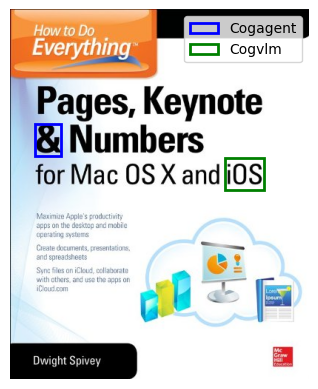

Low IoU (0.37) for 73e50722-91f9-4c9b-8bb8-7d0711083213 - <REASONING>:
Model 1 Content: title
Model 2 Content: title


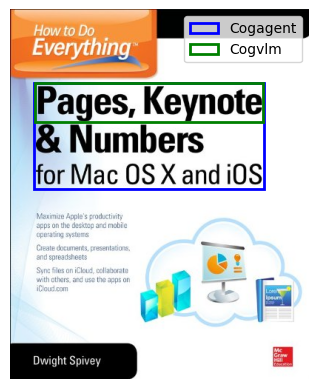

Low IoU (0.00) for 73e50722-91f9-4c9b-8bb8-7d0711083213 - <REASONING>:
Model 1 Content: subtitle
Model 2 Content: subtitle


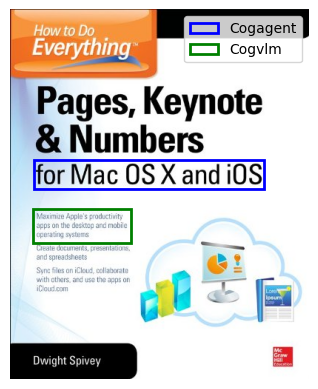

Low IoU (0.11) for 73e50722-91f9-4c9b-8bb8-7d0711083213 - <REASONING>:
Model 1 Content: Apple\'s productivity apps
Model 2 Content: Apple\'s productivity apps


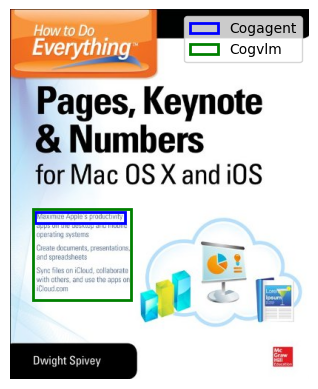

Low IoU (0.43) for 849966a5-26c6-4d8c-b782-068f3e081c83 - <CAPTION>:
Model 1 Content: north-central part of the map
Model 2 Content: north-central part of the map


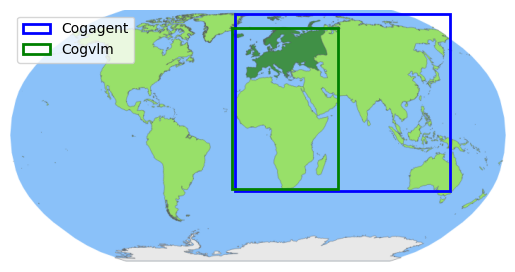

Low IoU (0.20) for 849966a5-26c6-4d8c-b782-068f3e081c83 - <REASONING>:
Model 1 Content: landmass
Model 2 Content: landmass


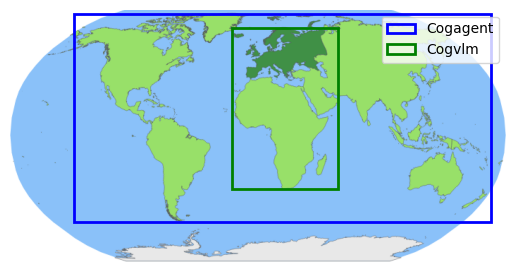

Low IoU (0.26) for 849966a5-26c6-4d8c-b782-068f3e081c83 - <REASONING>:
Model 1 Content: countries within this region
Model 2 Content: countries within this region


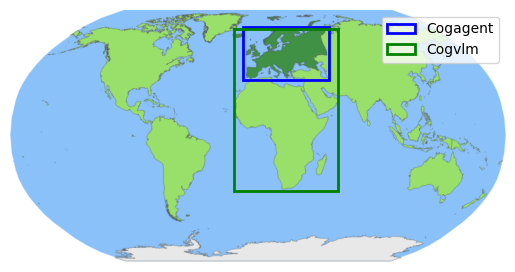

Low IoU (0.00) for 24eb93cb-9e82-4ce3-a35a-5e2e763b6f53 - <CAPTION>:
Model 1 Content: yellow embedded items
Model 2 Content: yellow embedded items


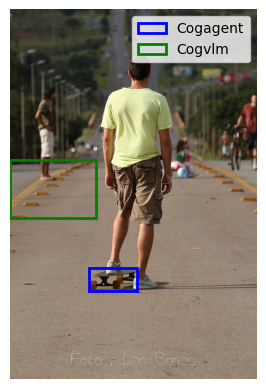

Low IoU (0.15) for 24eb93cb-9e82-4ce3-a35a-5e2e763b6f53 - <CAPTION>:
Model 1 Content: centerline
Model 2 Content: centerline


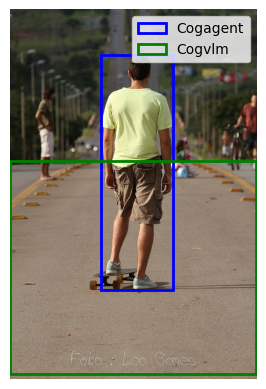

Low IoU (0.00) for 24eb93cb-9e82-4ce3-a35a-5e2e763b6f53 - <REASONING>:
Model 1 Content: yellow embedded items
Model 2 Content: yellow embedded items


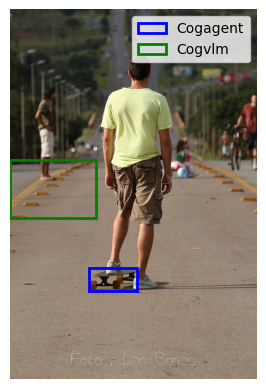

In [29]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2
    
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area != 0 else 0

def visualize_bbox(image_path, bbox1, bbox2):
    image = Image.open(image_path)
    width, height = image.size
    
    bbox1 = [b * (width if i % 2 == 0 else height) for i, b in enumerate(bbox1)]
    bbox2 = [b * (width if i % 2 == 0 else height) for i, b in enumerate(bbox2)]
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2] - bbox1[0], bbox1[3] - bbox1[1], linewidth=2, edgecolor='b', facecolor='none')
    rect2 = patches.Rectangle((bbox2[0], bbox2[1]), bbox2[2] - bbox2[0], bbox2[3] - bbox2[1], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    
    plt.legend(["Cogagent", "Cogvlm"])
    
    plt.axis('off')
    plt.show()

def process_predictions(file1, file2, start_index=0, num_samples=10):
    data1 = load_json(file1)
    data2 = load_json(file2)

    data1_dict = {entry['id']: entry for entry in data1}
    data2_dict = {entry['id']: entry for entry in data2}

    i = 0
    visualized_samples = 0
    for entry_id in data1_dict.keys() & data2_dict.keys():
        if visualized_samples >= num_samples:
            break

        entry1 = data1_dict[entry_id]
        entry2 = data2_dict[entry_id]

        if entry1['image'].startswith(prefix_to_remove):
            new_path = entry1['image'][len(prefix_to_remove):]
        else:
            new_path = entry1['image']

        entry1['image'] = new_path
        image_path = os.path.join(image_base_dir, new_path)

        for convo1, convo2 in zip(entry1.get("conversations", []), entry2.get("conversations", [])):
            for tag1, bboxes1 in convo1.items():
                bboxes2 = convo2.get(tag1, [])
                if not bboxes1 or not bboxes2:
                    continue

                for bbox1, bbox2 in zip(bboxes1, bboxes2):
                    # Verify that both are dictionary objects with 'bbox' keys
                    if not isinstance(bbox1, dict) or not isinstance(bbox2, dict):
                        # print("Error: bbox is not a dictionary!")
                        continue

                    if 'bbox' not in bbox1 or 'bbox' not in bbox2:
                        print("Error: bbox key not found!")
                        continue

                    if bbox1['bbox'] is None or bbox2['bbox'] is None:
                        continue
                    if bbox1['bbox'] is None or bbox2['bbox'] is None:
                        continue

                    iou = calculate_iou(bbox1['bbox'], bbox2['bbox'])
                    if iou < 0.5:
                        if i >= start_index:
                            print(f"Low IoU ({iou:.2f}) for {entry_id} - {tag1}:")
                            print("Model 1 Content:", bbox1['content'])
                            print("Model 2 Content:", bbox2['content'])
                            visualize_bbox(image_path, bbox1['bbox'], bbox2['bbox'])
                            visualized_samples += 1
                            if visualized_samples >= num_samples:
                                return
                        i += 1

image_base_dir = "/mnt/pfs-mc0p4k/nlu/team/yuhaofu/data/LLaVA-CoT-100k"
prefix_to_remove = "/lpai/volumes/ss-nlu-ali-sh/lizr/yuhaofu/data/LLaVa-CoT-100k/"

path1 = '/mnt/pfs-mc0p4k/nlu/team/yuhaofu/data/LLaVA-CoT-100k/json/1_10/cogagent/filter_entire_image_caption.json'
path2 = '/mnt/pfs-mc0p4k/nlu/team/yuhaofu/data/LLaVA-CoT-100k/json/filter_entire_image_caption.json'

# Visualize samples from index 10 to 19
process_predictions(path1, path2, start_index=200, num_samples=10)